In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalizatio
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
df = pd.read_csv('/content/final_df_updated.csv')

df.fillna(0, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.select_dtypes(include=[np.number])
features = df.drop(columns=['Total Counts'])
target = 'Total Counts'
scaler = MinMaxScaler()
df[features.columns.tolist() + [target]] = scaler.fit_transform(df[features.columns.tolist() + [target]])
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)
seq_length = 10
X, y = create_sequences(df[features.columns.tolist() + [target]].values, seq_length)


In [39]:
df.head(2)

,Year,Month,Total Counts,Classic Bike Count,Electric Bike Count,Docked Bike Count,Electric Scooter Count,Casual User Count,Member User Count
0,0.0,0.272727,0.045426,0.0,0.0,0.152429,0.0,0.031248,0.049800
1,0.0,0.363636,0.194675,0.0,0.0,0.360098,0.0,0.177758,0.169871


In [40]:
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size, -1]
X_test, y_test = X[train_size:], y[train_size:, -1]


In [41]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, len(features.columns) + 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
###preprocess = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])])


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=500, batch_size=128, verbose=0)

y_pred = model.predict(X_test)

y_test_real = scaler.inverse_transform(np.column_stack((np.zeros((len(y_test), len(features.columns))), y_test)))[:, -1]
y_pred_real = scaler.inverse_transform(np.column_stack((np.zeros((len(y_pred), len(features.columns))), y_pred.flatten())))[:, -1]




In [57]:
def predict_future(model, last_sequence, months=6):
    future_preds = []
    current_seq = last_sequence.copy()

    for _ in range(months):
        pred = model.predict(current_seq.reshape(1, seq_length, -1))
        future_preds.append(pred[0, 0])
        new_entry = np.append(current_seq[1:], [[*current_seq[-1, :-1], pred[0, 0]]], axis=0)
        current_seq = new_entry

    return np.array(future_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


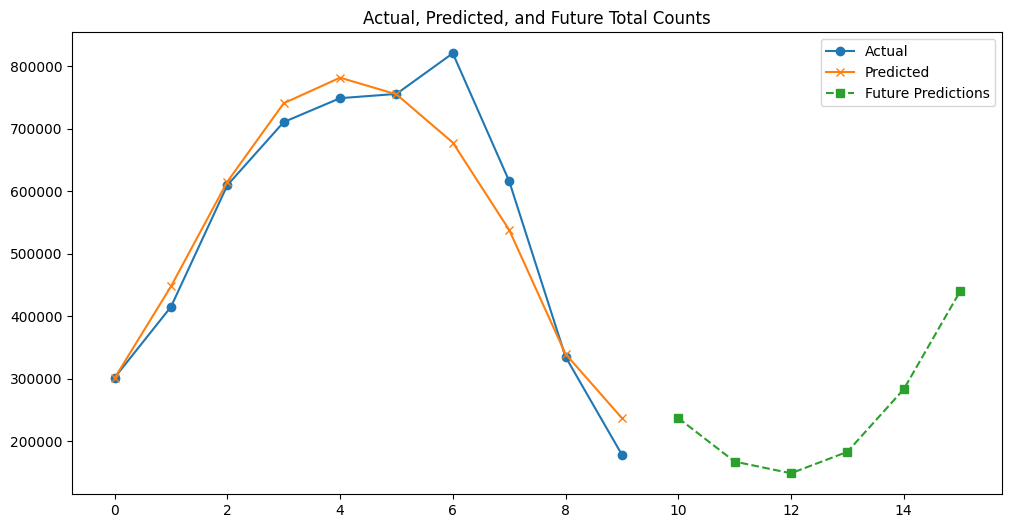

 MAPE: 8.20%, R² Score: 0.9271
Future Predictions for Next 6 Months:
[236977.81 167303.98 148574.94 182923.83 282992.16 439755.6 ]


In [58]:
future_predictions = predict_future(model, X_test[-1], months=6)
future_predictions_real = target_scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Actual', marker='o')
plt.plot(y_pred_real, label='Predicted', marker='x')
plt.plot(range(len(y_test_real), len(y_test_real) + 6), future_predictions_real, label='Future Predictions', marker='s', linestyle='dashed')
plt.legend()
plt.title('Actual, Predicted, and Future Total Counts')
plt.show()










mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100
r2 = r2_score(y_test_real, y_pred_real)

print(f' MAPE: {mape:.2f}%, R² Score: {r2:.4f}')
print("Future Predictions for Next 6 Months:")
print(future_predictions_real)